# 逻辑回归

Computing regularization path ...
This took 0.041s


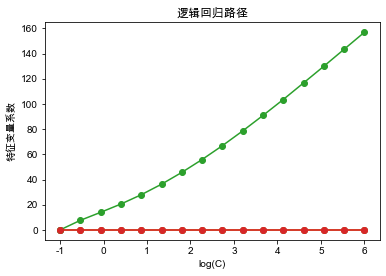

In [1]:
# 不同的C参数，对于正则化路径的影响
# Author: Alexandre Gramfort <alexandre.gramfort@inria.fr>
# License: BSD 3 clause

from time import time
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

from sklearn import linear_model
from sklearn import datasets
from sklearn.svm import l1_min_c

iris = datasets.load_iris()
X = iris.data
y = iris.target

X = X[y != 2]
y = y[y != 2]

X /= X.max()  # Normalize X to speed-up convergence

# #############################################################################
# Demo path functions

cs = l1_min_c(X, y, loss='log') * np.logspace(0, 7, 16)

print("Computing regularization path ...")
start = time()
clf = linear_model.LogisticRegression(penalty='l1', solver='liblinear',
                                      tol=1e-6, max_iter=int(1e6),
                                      warm_start=True,
                                      intercept_scaling=10000.)
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(X, y)
    coefs_.append(clf.coef_.ravel().copy())
print("This took %0.3fs" % (time() - start))

coefs_ = np.array(coefs_)
plt.plot(np.log10(cs), coefs_, marker='o')
ymin, ymax = plt.ylim()
plt.xlabel('log(C)')
plt.ylabel('特征变量系数')
plt.title('逻辑回归路径')
plt.axis('tight')
plt.show()

In [ ]:
# Plot multinomial and One-vs-Rest Logistic Regression

# Authors: Tom Dupre la Tour <tom.dupre-la-tour@m4x.org>
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression

# make 3-class dataset for classification
centers = [[-5, 0], [0, 1.5], [5, -1]]
X, y = make_blobs(n_samples=1000, centers=centers, random_state=40)
transformation = [[0.4, 0.2], [-0.4, 1.2]]
X = np.dot(X, transformation)

for multi_class in ('multinomial', 'ovr'):
    clf = LogisticRegression(solver='sag', max_iter=100, random_state=42,
                             multi_class=multi_class).fit(X, y)

    # print the training scores
    print("training score : %.3f (%s)" % (clf.score(X, y), multi_class))

    # create a mesh to plot in
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.title("Decision surface of LogisticRegression (%s)" % multi_class)
    plt.axis('tight')

    # Plot also the training points
    colors = "bry"
    for i, color in zip(clf.classes_, colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired,
                    edgecolor='black', s=20)

    # Plot the three one-against-all classifiers
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    coef = clf.coef_
    intercept = clf.intercept_

    def plot_hyperplane(c, color):
        def line(x0):
            return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]
        plt.plot([xmin, xmax], [line(xmin), line(xmax)],
                 ls="--", color=color)

    for i, color in zip(clf.classes_, colors):
        plot_hyperplane(i, color)

plt.show()

In [ ]:
# L1 Penalty and Sparsity in Logistic Regression

# Authors: Alexandre Gramfort <alexandre.gramfort@inria.fr>
#          Mathieu Blondel <mathieu@mblondel.org>
#          Andreas Mueller <amueller@ais.uni-bonn.de>
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

X, y = datasets.load_digits(return_X_y=True)

X = StandardScaler().fit_transform(X)

# classify small against large digits
y = (y > 4).astype(int)

l1_ratio = 0.5  # L1 weight in the Elastic-Net regularization

fig, axes = plt.subplots(3, 3)

# Set regularization parameter
for i, (C, axes_row) in enumerate(zip((1, 0.1, 0.01), axes)):
    # turn down tolerance for short training time
    clf_l1_LR = LogisticRegression(C=C, penalty='l1', tol=0.01, solver='saga')
    clf_l2_LR = LogisticRegression(C=C, penalty='l2', tol=0.01, solver='saga')
    clf_en_LR = LogisticRegression(C=C, penalty='elasticnet', solver='saga',
                                   l1_ratio=l1_ratio, tol=0.01)
    clf_l1_LR.fit(X, y)
    clf_l2_LR.fit(X, y)
    clf_en_LR.fit(X, y)

    coef_l1_LR = clf_l1_LR.coef_.ravel()
    coef_l2_LR = clf_l2_LR.coef_.ravel()
    coef_en_LR = clf_en_LR.coef_.ravel()

    # coef_l1_LR contains zeros due to the
    # L1 sparsity inducing norm

    sparsity_l1_LR = np.mean(coef_l1_LR == 0) * 100
    sparsity_l2_LR = np.mean(coef_l2_LR == 0) * 100
    sparsity_en_LR = np.mean(coef_en_LR == 0) * 100

    print("C=%.2f" % C)
    print("{:<40} {:.2f}%".format("Sparsity with L1 penalty:", sparsity_l1_LR))
    print("{:<40} {:.2f}%".format("Sparsity with Elastic-Net penalty:",
                                  sparsity_en_LR))
    print("{:<40} {:.2f}%".format("Sparsity with L2 penalty:", sparsity_l2_LR))
    print("{:<40} {:.2f}".format("Score with L1 penalty:",
                                 clf_l1_LR.score(X, y)))
    print("{:<40} {:.2f}".format("Score with Elastic-Net penalty:",
                                 clf_en_LR.score(X, y)))
    print("{:<40} {:.2f}".format("Score with L2 penalty:",
                                 clf_l2_LR.score(X, y)))

    if i == 0:
        axes_row[0].set_title("L1 penalty")
        axes_row[1].set_title("Elastic-Net\nl1_ratio = %s" % l1_ratio)
        axes_row[2].set_title("L2 penalty")

    for ax, coefs in zip(axes_row, [coef_l1_LR, coef_en_LR, coef_l2_LR]):
        ax.imshow(np.abs(coefs.reshape(8, 8)), interpolation='nearest',
                  cmap='binary', vmax=1, vmin=0)
        ax.set_xticks(())
        ax.set_yticks(())

    axes_row[0].set_ylabel('C = %s' % C)

plt.show()

